# Entendimiento de los datos con PySpark - Proyecciones

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [3]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [4]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_13_202314'
db_psswd = 'aabb1122'

PATH='./'

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [6]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [9]:
sql_proyecciones = 'ProyectoTransaccional.proyeccionesCopia'

In [10]:
sql_detallesproyecciones = '''(SELECT 
        Anio, 
        DP, 
        ID_Producto, 
        DPNOM, 
        Total Hombres, 
        Total Mujeres
        FROM'ProyectoTransaccional.proyeccionesCopia) AS Compatible'''

In [12]:
#Se cargan los dataframes desde la base de datos
proyecciones = obtener_dataframe_de_bd(db_connection_string, sql_proyecciones, db_user, db_psswd)


### Entendimiento general de datos

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [14]:
proyecciones.show(5)

+----+---+---------+-------------+-------------+
|Anio| DP|    DPNOM|Total Hombres|Total Mujeres|
+----+---+---------+-------------+-------------+
|2005| 25|antioquia|      2630787|      2830056|
|2006| 25|antioquia|      2663957|      2864164|
|2007| 25|antioquia|      2697202|      2897978|
|2008| 25|antioquia|      2730505|      2931594|
|2009| 25|antioquia|      2764235|      2966142|
+----+---+---------+-------------+-------------+
only showing top 5 rows



In [15]:
proyecciones.schema

StructType(List(StructField(Anio,IntegerType,true),StructField(DP,IntegerType,true),StructField(DPNOM,StringType,true),StructField(Total Hombres,IntegerType,true),StructField(Total Mujeres,IntegerType,true)))

Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**. Del pedido se tiene el identificador del detalle <i>Detalle_orden_ID</i>, el identificador de la orden a la que está relacionado cada detalle <i>ID_de_pedido</i>, la <i>Cantidad_seleccionada</i> del producto para la orden, la fecha de selección <i>Seleccion_completada_cuando</i>. Del producto tenemos el <i>ID_Producto</i>, su <i>Descripcion</i>, el tipo de paquete <i>ID_Tipo_Paquete</i> (Ej. 1.Bolsa, 4. Caja), la <i>Cantidad</i>, el <i>Precio_unitario</i>, y la <i>Tasa_impuesto</i> asociada a ese producto. Una primera aclaración a solicitar por parte del negocio es cuál es la diferencia entre cantidad y cantidad seleccionada

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [16]:
print((proyecciones.count(), len(proyecciones.columns)))

(330, 5)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 58.320 órdenes y 88.258 detalles de orden y tenemos en total 24 variables a revisar de las cuales 8 son nùmericas asociadas a las órdenes, dos son de tipo fecha y las demás son cadenas de caracteres.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera que asegura que la tasa de impuesto es de 10% o 15% vemos que no es correcta pues al seleccionar esa columna e indicar que queremos ver los valores distintos que puede tomar se observa únicamente el valor 15

In [27]:
proyecciones.select("Total Hombres").where((col('DPNOM')=='valle del cauca')).where((col('Anio')=='2014')).distinct().show()

+-------------+
|Total Hombres|
+-------------+
|      2110069|
+-------------+



Si se quiere saber cuántos registros hay por cada valor posible, existen varias formas de hacerlo, en la siguiente celda se muestra cómo iterar sobre los valores resultado de una consulta y cómo filtrar el número de registros para cada valor usando filter y select where, también se da un ejemplo de uso de group by y agregaciones

Pyspark tiene funcionalidades de los DataFrames que permiten explorar los datos por medio de agregaciones y estas funcionan similar a como se usan en SQL

Primero, se debe agrupar sobre una columna con el método <i>groupBy</i> y después se pueden realizar agregaciones sobre otras columnas con el método <i>agg</i>. La sintaxis es la siguiente: 
 ``` 
    DataFrame.groupBy('COLUMN NAME').agg({'COLUMN NAME 1': 'mean', 'COLUMN NAME 2': 'count', 'COLUMN NAME 3': 'max'})
  ``` 

En cualquiera de los 3 casos se observa que el resultado es el mismo

In [31]:
proyecciones.groupBy("DPNOM").count().show(100)

+--------------------+-----+
|               DPNOM|count|
+--------------------+-----+
|               sucre|   10|
|              caldas|   10|
|              vaupes|   10|
|           antioquia|   10|
|                meta|   10|
|archipielago de s...|   10|
|             quindio|   10|
|            guaviare|   10|
|               cesar|   10|
|             cordoba|   10|
|           risaralda|   10|
|          la guajira|   10|
|           santander|   10|
|        cundinamarca|   10|
|               choco|   10|
|             guainia|   10|
|           magdalena|   10|
|           atlantico|   10|
|               cauca|   10|
|            putumayo|   10|
|              tolima|   10|
|              arauca|   10|
|              boyaca|   10|
|             vichada|   10|
|             nariÃ±o|   10|
|            amazonas|   10|
|            casanare|   10|
|     valle del cauca|   10|
|  norte de santander|   10|
|               huila|   10|
|             caqueta|   10|
|        bogot

La conclusión es entonces que la regla no es completamente cierta, pues en los datos no hay ningun registro con tasa_de_impuesto de 10%, es necesario pedir aclaraciones al negocio en relación a este descubrimiento. La segunda regla de negocio implica conocer el número de registros y de variables que los describen, es decir, el número de filas y columnas del DataFrame respectivamente, esto se logra usando count() y columns

In [32]:
print((proyecciones.count(), len(proyecciones.columns)))

(330, 5)


Algo que se debe tener en cuenta en el perfilamiento de reglas de negocio es que dichas reglas pueden estar incompletas, por ende se recomienda tener especial cuidado con las columnas tipo caracter o string dado que suelen ser pasadas por alto en el análisis estadistico, un ejemplo es la columna **Descripcion**, al ser una columna de descripción del producto se espera que tenga un cierto número de caracteres. Sin embargo haciendo la validación vemos que algunas descripciones son textos incompletos como "a". Este podría llegar a ser un problema a futuro por lo que se decide notificar a la organización.

In [37]:
proyecciones.where(length(col("Anio")) <= '2014').show()

+----+---+---------+-------------+-------------+
|Anio| DP|    DPNOM|Total Hombres|Total Mujeres|
+----+---+---------+-------------+-------------+
|2005| 25|antioquia|      2630787|      2830056|
|2006| 25|antioquia|      2663957|      2864164|
|2007| 25|antioquia|      2697202|      2897978|
|2008| 25|antioquia|      2730505|      2931594|
|2009| 25|antioquia|      2764235|      2966142|
|2010| 25|antioquia|      2798757|      3001403|
|2011| 25|antioquia|      2833245|      3035946|
|2012| 25|antioquia|      2866567|      3069349|
|2013| 25|antioquia|      2898803|      3102348|
|2014| 25|antioquia|      2930948|      3135858|
|2005| 25|atlantico|      1024962|      1089174|
|2006| 25|atlantico|      1040124|      1104675|
|2007| 25|atlantico|      1055195|      1119793|
|2008| 25|atlantico|      1070008|      1134356|
|2009| 25|atlantico|      1084589|      1148685|
|2010| 25|atlantico|      1098964|      1162692|
|2011| 25|atlantico|      1112916|      1176031|
|2012| 25|atlantico|

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [38]:
proyecciones.summary().show()

+-------+-----------------+----+--------+-----------------+------------------+
|summary|             Anio|  DP|   DPNOM|    Total Hombres|     Total Mujeres|
+-------+-----------------+----+--------+-----------------+------------------+
|  count|              330| 330|     330|              330|               330|
|   mean|           2009.5|25.0|    null|650666.4242424242| 843740.4454545454|
| stddev|2.876643180486918| 0.0|    null|751024.7851013226|3097897.0672473223|
|    min|             2005|  25|amazonas|            13825|             11636|
|    25%|             2007|  25|    null|           173396|            170374|
|    50%|             2009|  25|    null|           477977|            489035|
|    75%|             2012|  25|    null|           777720|            795592|
|    max|             2014|  25| vichada|          3476538|          55000000|
+-------+-----------------+----+--------+-----------------+------------------+



{'whiskers': [<matplotlib.lines.Line2D at 0x1d4fd2f8fc8>,
 'caps': [<matplotlib.lines.Line2D at 0x1d4fd367ac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d4fd34ca48>],
 'medians': [<matplotlib.lines.Line2D at 0x1d4fd3645c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d4fd367f88>],
 'means': []}

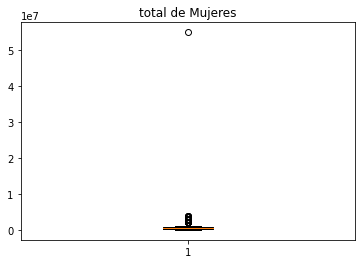

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('total de Mujeres')
ax1.boxplot(np.array(proyecciones.select('Total Mujeres').collect()))

{'whiskers': [<matplotlib.lines.Line2D at 0x1d4fd469f48>,
 'caps': [<matplotlib.lines.Line2D at 0x1d4fe53a748>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d4fd469648>],
 'medians': [<matplotlib.lines.Line2D at 0x1d4fe540988>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d4fe540bc8>],
 'means': []}

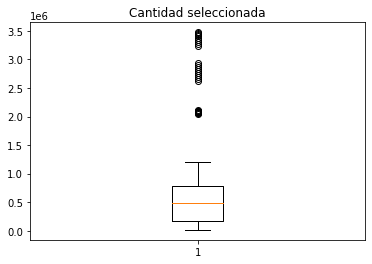

In [42]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad seleccionada')
my_list = [float(i) for i in proyecciones.select(f.collect_list('Total Hombres')).first()[0]]
ax1.boxplot(my_list)

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

In [43]:
proyecciones.groupby("DPNOM").count().orderBy("count", ascending=False).show(5)

+---------+-----+
|    DPNOM|count|
+---------+-----+
|    sucre|   10|
|   caldas|   10|
|   vaupes|   10|
|antioquia|   10|
|     meta|   10|
+---------+-----+
only showing top 5 rows



## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [44]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [45]:
columnas_vacias_ordenes = contar_vacios(proyecciones)


In [46]:
columnas_alta_cardinalidad_proyecciones = cardinalidad(proyecciones)
columnas_alta_cardinalidad_proyecciones

{'Total Hombres': 329, 'Total Mujeres': 329}

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [59]:
#consistencia: revisar genially: definicion de consistencia
ids_proyecciones = set([x.DPNOM for x in proyecciones.select('DPNOM').collect()])
len(ids_proyecciones)

33

Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cuáles son los registros que pueden tener ids que no existen

## Herramientas para facilitar el entendimiento de datos

Algunas de las estadísticas antes desarrolladas pueden obtenerse por medio de herramientas como Pandas Profiling una herramienta muy útil, <b><i>Pero no perfecta ni completa</i></b>, es Pandas profiling que dado un conjunto de datos, nos muestra histogramas, estadísticas etc. A continuación guardamos el reporte en html

In [50]:
reporte = ProfileReport(proyecciones.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 124.99it/s]


<b>Cabe aclarar que un pandas profiling sin interpretación no es suficiente como análisis para realizar el entendimiento de los datos.

Así mismo, recuerde que si es necesario, se debe utilizar otra herramienta (código, visualizaciones, etc) para poder completar el análisis estadístico.</b>

### Algunas gráficas utiles: Diagrama de caja, dispersion, histogramas para entender las distribuciones de las variables

Generalmente las gráficas se emplean para entender la distribución de cada variable, también sirven para visualizar la relación entre 2 o más variables

Algunas gráficas útiles son los histogramas, disepersión, diagramas de caja. Hay varias maneras de implementarlos, con paquetes como matplotlib o pandas, con funciones propias de pyspark, etc, a continuacón mostramos cómo hacerlo a travez de pandas

array([[<AxesSubplot:title={'center':'Total Mujeres'}>]], dtype=object)

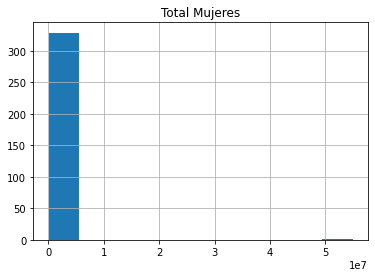

In [51]:
#para valores extremos(subir a calidad)
proyecciones.toPandas().hist(column='Total Mujeres')

In [52]:
cantidades = proyecciones.groupby("Total Hombres").count().orderBy("count", ascending=False)

Como se puede observar, el método retorna un dataframe, que vamos a usar para obtener dos arreglos, uno con el rango de cada una de las barras y otro con la cantidad de registros por rango. Se puede usar Matplotlib para graficar esta información:

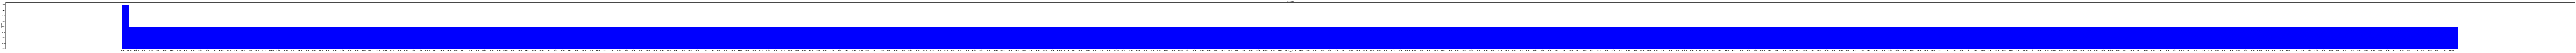

In [53]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

plotHistogramData(cantidades)

El diagrama de dispersion, nos muestra los datos para dos variables en forma de puntos y es muy útil para entender la relación entre dichas variables

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>Fecha_de_pedido</i> y por cada <i>ID_de_vendedor</i>, es decir por fecha y por empleado cuantas ordenes existen:

In [56]:
proyecciones.groupBy('Anio').pivot('Total Hombres').count().show()

+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+---

Otro análisis muy útil es el de la correlación lineal entre dos variables, para ver la matriz de correlacion que mide esta dependencia o la fuerza de la relación lineal entre dos variables vamos a usar pandas, la interpretación es que si entre dos variables A y B  el valor obtenido es cercano a -1 o a 1, se interpreta como que A y B contienen la misma información y por ende no es necesario mantener ambas columnas

In [57]:
corr = proyecciones.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Anio,DP,Total Hombres,Total Mujeres
Anio,1.000000,nan,0.026346,-0.002607
DP,nan,nan,nan,nan
Total Hombres,0.026346,nan,1.000000,0.218155
Total Mujeres,-0.002607,nan,0.218155,1.000000


## Conclusiones/resultados

## Tabla proyeccionesCopia

## 1. **Completitud de los datos:**

> ### 1.1 **Cantidad de registros y cantidad de columnas por tipo de dato:**

 
> Como se puede ver en la imagen anterior se logra generar el esquema de un DataFrame de la tabla ProyeccionesCopia el cual incluye los nombres de las columnas así como el tipo de dato de cada una de ellas. Ademas se logra identificar que la tabla solo tiene 9 columnas y 330 filas.



En la anterior imagen se logra identifcar que la regla de negocio que habla de que en el valle del cauca hay 210069 hombres es verdicia, es decir se confirma.

>   
> ### 1.2 **Significado de una Fila:**

> Al observar una fila de la tabla proyeccionesCopia se puede identificar que corresponde a la información que se genera cuando se realiza una proyeccion entre los departmamentos, la cantidad de hombres y de mujeres que son clientes potenciales para la compañia, Es aqui donde se almacena informacion que puede ser util en el futuro.


> ### 1.3 **Estadística descriptiva:**


> Al observar la imagen anterior se puede inferir  varias cosas lo primero es que todas las columnas de cada una de las filas tiene informacion coherente, que el año promedio de las proyeciones es el 2009, en toda la tabla hay un promedio de 650666 hombres y de un promedio de 843740 mujeres, ademas que el departmenot con menos hombres y mejuers es el amazones y el que tiene mas es el vichada.



> En la anterior imagen se puede observar la distrubución de hombres y mujeres en toda la tabla.


De la anterior imagen se puede decir que los departmentos que tienen mas registros son los que se ven alli.

## 2. **Análisis de los datos:**

> ### 2.1 **Completitud de los datos:**

> Como se puede identificar en la siguente imagen se didentifica que la tabla es valida y completa dado que no existen columnas que se encuntren vacias o sin infromación



> ### 2.2 **Unicidad de lso datos:**



como se puede indentificar en la imagen anterior tenemos unicidad por que al comparar las filas sobre los hombres y sobre las mujeres vemos que ambos datoa tieenen la misma cantidad de registros es decir la tabla tiene una alta unicidad sobre estos campos.


> ### 2.3 **Consistencia:**



> En la imagen anterior se muestra que los datos se encuentran correctamente analizados, dado que no existen mas 32 departmantos y si aunamdo a eso le sumamos el distrito capitial como ente independientese observan los 33 datos alli mostrados.


> ### 2.3 **Validez:**

> Desde mi punto de vista y al identificar, analizar y ver las columnas con relacion a cada una de las filas esta tabla si es valida, dado que no hay incositncias de informacion, no existen nulos, ni vacios ni mucho menos informacion incomprensible sobre cada uno de los datos de esta.



## 3. **Conclusión:**

> ### 3.1 **Análisis basado en tableros:**
Yo diria que si se puede hacer analisis basado en tableros dado la informacion es veraz, unificada y valida. Sin embargo  hay que identificar el propsito de la tabla según las demas tablas.
> 

> ### 3.2 **Fila Promedio:**
Esta fila promedio proporcionaria informacion generalizada de las proyecciones en terminos de género a lo largo de todos los departamentos y años.

> ### 3.3. Solución de Preguntas:

> ### 3.4. Dudas o Supuestos:

Para este apartado no me queda claro está tabla como se relaciona con los vuelos y los viajes, a noser de que sea proyeciones de los posibles clientes que se peudan tner en un año para que viajen en avion.
